## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [90]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = "https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/"

fileName = 'jet.bmp'
if not os.path.exists(fileName) :
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

jet = cv2.imread('jet.bmp', cv2.IMREAD_GRAYSCALE)

print(jet)

[[193 185 178 ... 165 164 147]
 [191 195 194 ... 178 156 139]
 [193 197 194 ... 190 156 140]
 ...
 [215 212 208 ... 205 208 212]
 [217 211 208 ... 192 188 191]
 [213 211 211 ... 184 176 149]]


In [91]:
def show_image( image ):
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.show()

def generate_histogram(image, channels = [0]):
    return image, cv2.calcHist(
        [image],
        channels,
        None,
        [256],
        [0,256]
    )

def rescale(image):
    min_image = min(image)
    max_image = max(image)
    return (image - min_image) / (max_image - min_image) * 255

def show_all_histograms(images = [], channels = [0]):
    prepared = []

    for image in images:
        prepared.append(generate_histogram(image, channels))

    fig, axs = plt.subplots( len(prepared), 2 )
    fig.set_size_inches(10, 5 * len(prepared))

    if len(prepared) == 1:
        image, hist = prepared[0]
        axs[0].imshow(image, 'gray', vmin=0, vmax=256)
        axs[1].plot(rescale(hist))
        axs[1].plot(rescale(hist.cumsum()))
        axs[1].grid()
    else:
        for i in range(len(prepared)):
            image, hist = prepared[i]
            axs[i,0].imshow(image, 'gray', vmin=0, vmax=256)
            axs[i,1].plot(rescale(hist))
            axs[i,1].plot(rescale(hist.cumsum()))
            axs[i,1].grid()
    
    plt.show()

def generate_histogram(image, channels = [ 0 ]):
    return image, cv2.calcHist(
        [image],
        channels,
        None,
        [256],
        [0,256]
    )

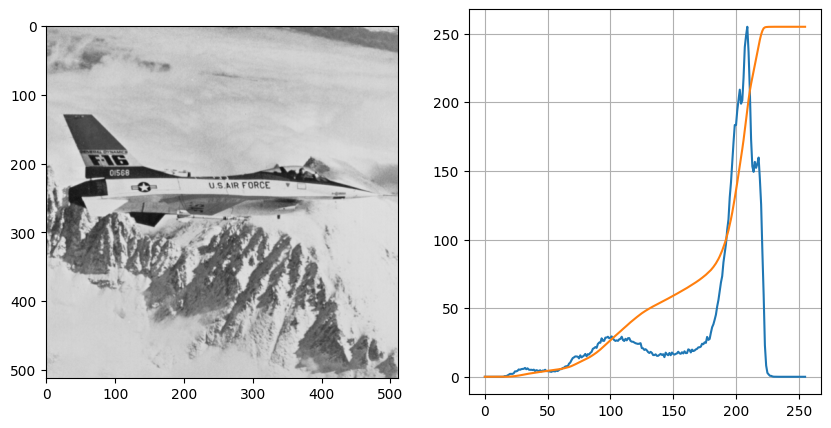

In [92]:
show_all_histograms([jet])

Z poprzedniego zadania:

In [93]:
def equalize_histogram(image):
    _, hist = generate_histogram(image)
    cumsum = hist.cumsum()
    lut = cumsum * 255 / cumsum[-1]
    lut = lut.astype('uint8')
    return cv2.LUT(image, lut)

Wszystkie wyniki


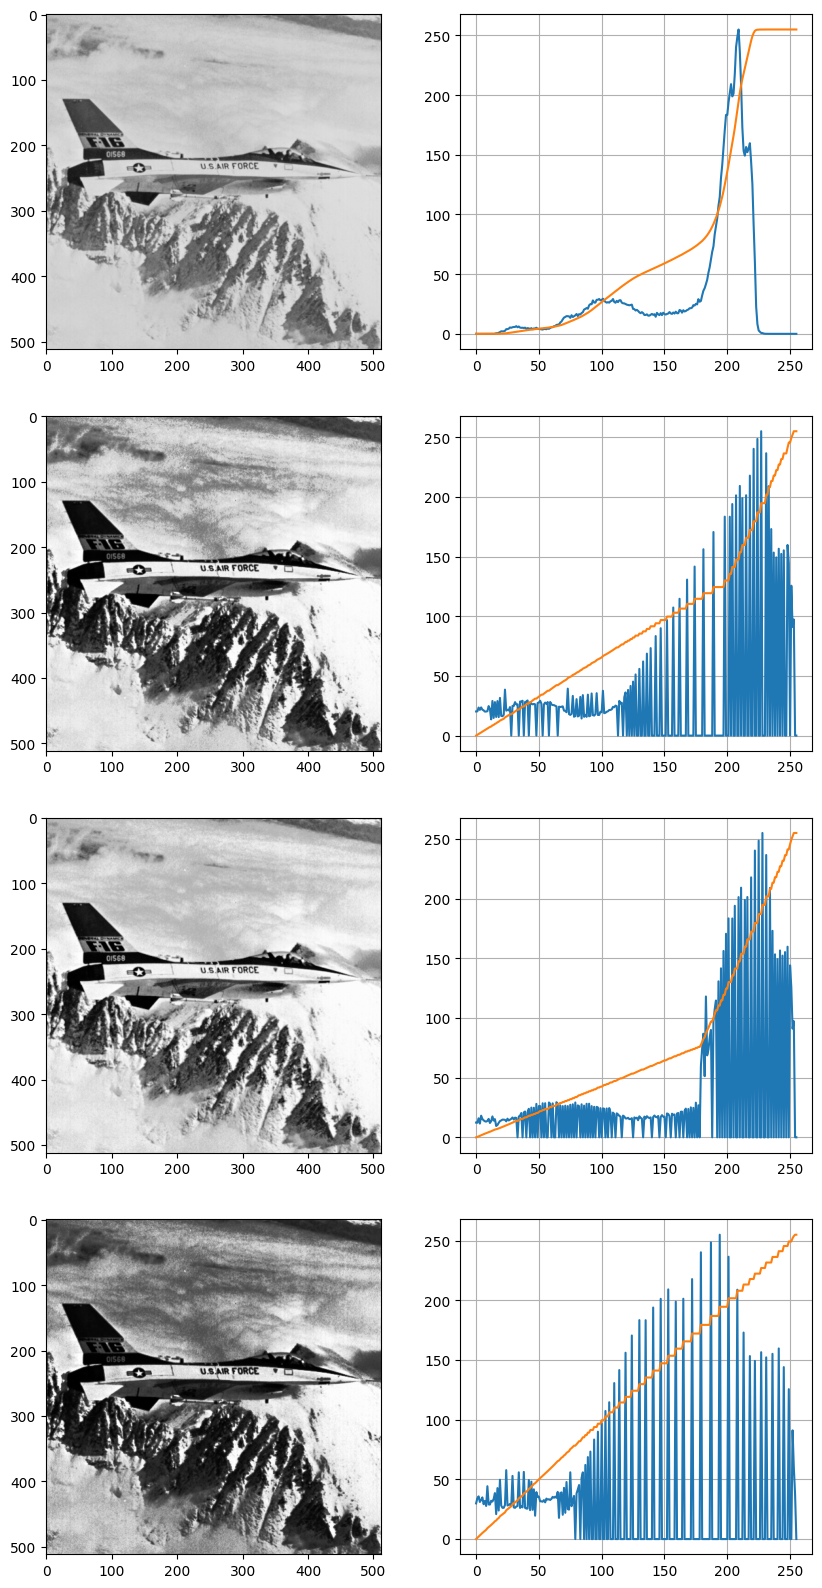

In [94]:
def rescale_to_range(array, min_v, max_v):
    return array * (max_v - min_v - 1) + min_v

def split_array(array, index):
    return array[:index + 1], array[index + 1:]

def normalize_histogram(histogram):
    return histogram / np.max(histogram)

def common_equalizer(image, hist, mid_point):
    hist1, hist2 = split_array(hist, mid_point)

    cumsum1 = hist1.cumsum()
    cumsum2 = hist2.cumsum()

    cumsum1 = normalize_histogram(cumsum1)
    cumsum2 = normalize_histogram(cumsum2)

    cumsum1 = rescale_to_range(cumsum1, 0, mid_point).astype("uint8")
    cumsum2 = rescale_to_range(cumsum2, mid_point + 1, 255).astype("uint8")

    lut = np.concatenate([cumsum1, cumsum2], axis=0)

    return cv2.LUT(image, lut)

def dsihe_equalizer(image):
    _, hist = generate_histogram(image)
    cumsum = rescale(hist.cumsum()) - 128
    mid_point = np.argmax(cumsum > 0)

    return common_equalizer(image, hist, mid_point)


def bbhe_equalizer(image):
    _, hist = generate_histogram(image)
    mid_point = np.mean(image).astype('uint8')

    return common_equalizer(image, hist, mid_point)

print("Wszystkie wyniki")
show_all_histograms([
    jet,
    dsihe_equalizer(jet),
    bbhe_equalizer(jet),
    equalize_histogram(jet)
])

### BBHE vs HE
Poniżej prezentują się kolejno: orginalny obraz, przetworzony przy pomocy BBHE oraz przy pomocy zwykłego HE. Obraz początkowy posiada najmniejszy kontrast. Obraz obrobiony używając BBHE otrzymał większy kontrast, przy małym ubytku na jasności.
Ostatni z nich (wykorzystujący zwykłe HE) okazał się być najciemniejszy.

Jak widzimy, nie zawsze jednostajna dystrybuanta daje najlepsze efekty

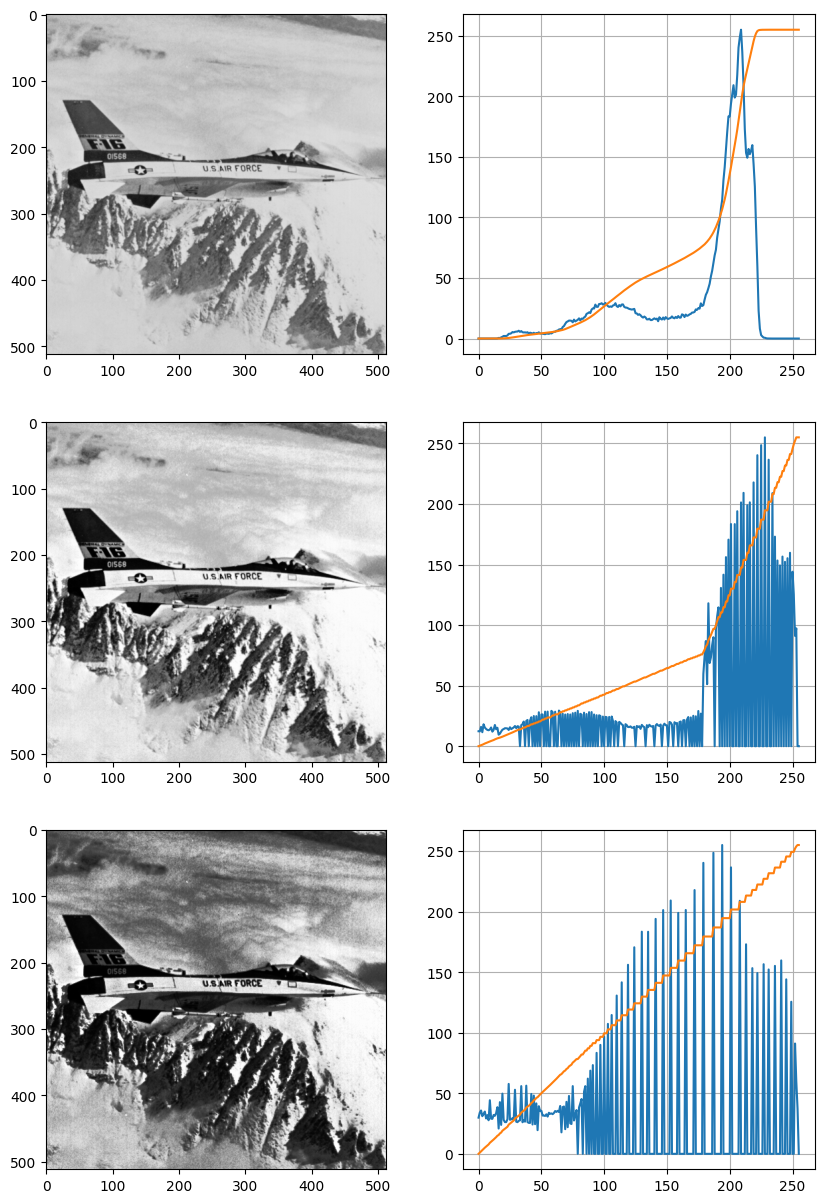

In [95]:
show_all_histograms([
    jet,
    bbhe_equalizer(jet),
    equalize_histogram(jet)
])

### DSIHE vs HE
Poniżej prezentują się kolejno: orginalny obraz, przetworzony przy pomocy DSIHE oraz przy pomocy zwykłego HE. Obraz początkowy posiada najmniejszy kontrast. Obraz obrobiony używając DSIHE otrzymał większy kontrast, przy małym ubytku na jasności. Dodatkowo, względem BBHE możemy zauważyć więcej ciemniejszych stref. Wynika to z wyboru punktu przedziału histogramu
Ostatni z nich (wykorzystujący zwykłe HE) okazał się być najciemniejszy.

Jak widzimy, nie zawsze jednostajna dystrybuanta daje najlepsze efekty

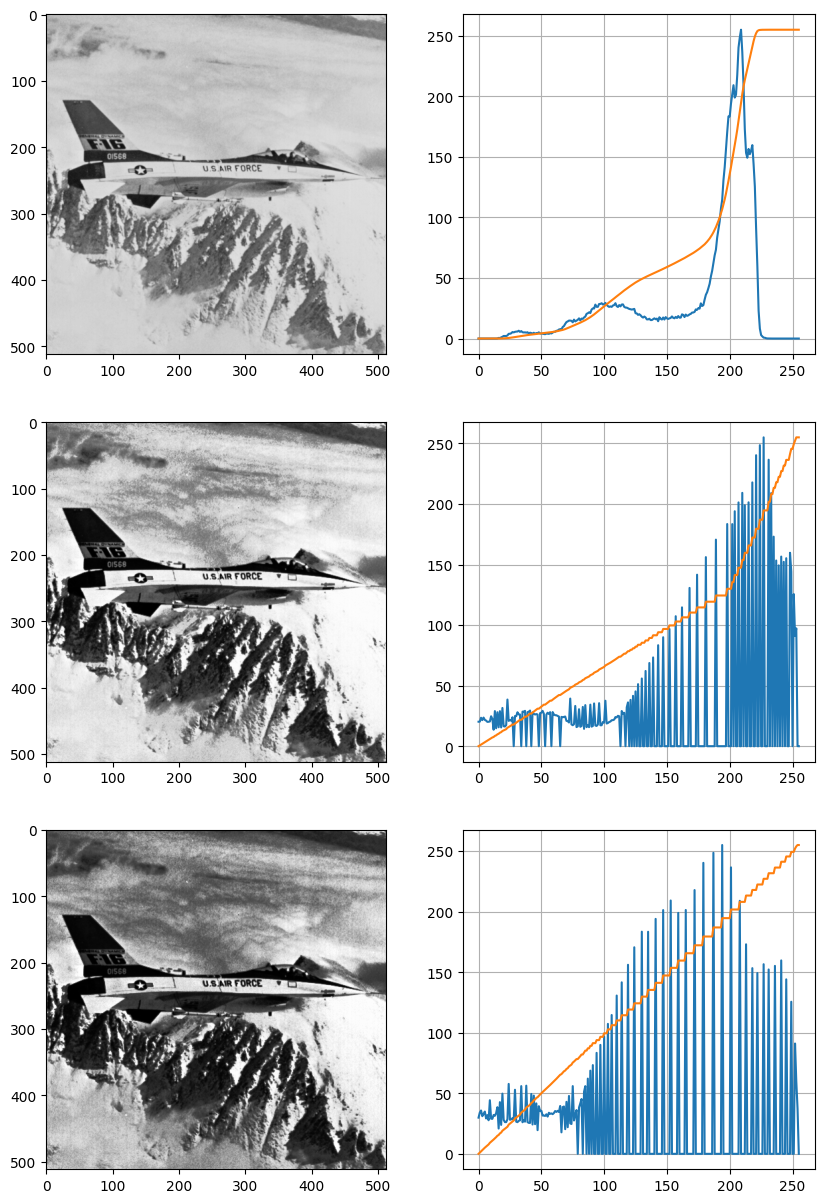

In [96]:
show_all_histograms([
    jet,
    dsihe_equalizer(jet),
    equalize_histogram(jet)
])